# Selection

## Prep Python

In [1]:
import os
import shutil
from IPython.display import Image
import rpy2.ipython
import allel

import matplotlib.pyplot as plt
import numpy as np

%load_ext rpy2.ipython

os.chdir("/master/nplatt/sch_man_nwinvasion")

get phased info (run beagle notebook if necessary)

## Prep R

In [2]:
%%R

library(ggplot2)
#library(tools) 
library(svglite)
#library(fields)

In [3]:
%%R

def_par<-par()

chr_colors <- c("SM_V7_1"    = "cadetblue", 
                "SM_V7_2"    = "darkslategray", 
                "SM_V7_3"    = "cadetblue", 
                "SM_V7_4"    = "darkslategray", 
                "SM_V7_5"    = "cadetblue", 
                "SM_V7_6"    = "darkslategray", 
                "SM_V7_7"    = "cadetblue", 
                "SM_V7_ZW"   = "darkslategray", 
                "SM_V7_MITO" = "cadetblue")

pop_colors <- c("west_africa"   = "red",
                "east_africa"   = "yellow", 
                "new_world"     = "green")

#-------------------------------------------------------------------------------------------------
#function to get cumulative positions for manhattan style plots
#  takes in a "SM_V7?" style chromosome name and outputs the "cumulative position" of that site


#set chromosome lengths
chr_lengths <- c( "SM_V7_1"    =  88881357,
                  "SM_V7_2"    =  48130368,
                  "SM_V7_3"    =  50458499,
                  "SM_V7_4"    =  47279781,
                  "SM_V7_5"    =  25256119,
                  "SM_V7_6"    =  24989083,
                  "SM_V7_7"    =  19288021,
                  "SM_V7_ZW"   =  88385488,
                  "SM_V7_MITO" =  26917      )

#get starting (cumulative start) per chromosome
cumul_starts <- vector()
cumul_starts["SM_V7_1"]    <- 0
cumul_starts["SM_V7_2"]    <- cumul_starts["SM_V7_1"]  + chr_lengths["SM_V7_1"]
cumul_starts["SM_V7_3"]    <- cumul_starts["SM_V7_2"]  + chr_lengths["SM_V7_2"]
cumul_starts["SM_V7_4"]    <- cumul_starts["SM_V7_3"]  + chr_lengths["SM_V7_3"]
cumul_starts["SM_V7_5"]    <- cumul_starts["SM_V7_4"]  + chr_lengths["SM_V7_4"]
cumul_starts["SM_V7_6"]    <- cumul_starts["SM_V7_5"]  + chr_lengths["SM_V7_5"]
cumul_starts["SM_V7_7"]    <- cumul_starts["SM_V7_6"]  + chr_lengths["SM_V7_6"]
cumul_starts["SM_V7_ZW"]   <- cumul_starts["SM_V7_7"]  + chr_lengths["SM_V7_7"]
cumul_starts["SM_V7_MITO"] <- cumul_starts["SM_V7_ZW"] + chr_lengths["SM_V7_ZW"]

get_cumul_pos <- function(chrom, pos){
    #empty the cumul_pos vector
    cumul_pos<-vector()
    
    for(i in seq(1, length(pos))){    

        if ( chrom[i] == "SM_V7_1" ) {
               start <- cumul_starts["SM_V7_1"]
           } else if ( chrom[i] == "SM_V7_2" ) {
               start <-cumul_starts["SM_V7_2"]
           } else if ( chrom[i] == "SM_V7_3" ) {
               start <- cumul_starts["SM_V7_3"]
           } else if ( chrom[i] == "SM_V7_4" ) {
               start <- cumul_starts["SM_V7_4"]
           } else if ( chrom[i] == "SM_V7_5" ) {
               start <- cumul_starts["SM_V7_5"]
           } else if ( chrom[i] == "SM_V7_6" ) {
               start <- cumul_starts["SM_V7_6"]
           } else if ( chrom[i] == "SM_V7_7" ) {
               start <- cumul_starts["SM_V7_7"]
           } else if ( chrom[i] == "SM_V7_ZW" ) {
               start <- cumul_starts["SM_V7_ZW"]
           } else if ( chrom[i] == "SM_V7_MITO" ) {
               start <- cumul_starts["SM_V7_MITO"]
           } else {
              print("ERROR UNRECOGNIZED CHR")
           }
        #set cul position for site
        cumul_pos[i]<-pos[i] +  start
    }
    return(cumul_pos)

}

# #was trying to get a more effiecientfunction but kept having issues with starts from chrZW and mito being
# #   being switched.
# get_cumul_pos <- function(chrom, pos){
#     #empty the cumul_pos vector
#     cumul_pos<-vector()
#     test<-vector()

#     #for each position
#     for( i in seq(1, length(chrom))){
#         #print(cumul_starts)
#         #add the position plus cumulitive start
#         cumul_pos[i] <- cumul_starts[chrom[i]] + pos[i]
#         print(paste(i, chrom[i], pos[i], cumul_starts[chrom[i]], cumul_pos[i], sep=" "))
#     }
#    
#     return(cumul_pos)
#    
# }

## Read in *PHASED* VCF Data

In [116]:
population_assignments = {
    "ERX284221"               : "other",
    "ERR310938"               : "rodhaini",
    "Sro_female_1.1_CCATCCTC" : "rodhaini",
    "Sro_female_1.2_CCGACAAC" : "rodhaini",
    "Sro_female_2.1_CCTAATCC" : "rodhaini",
    "Sro_female_2.2_CCTCTATC" : "rodhaini",
    "Sro_male_1.1_ATCATTCC"   : "rodhaini",
    "Sro_male_1.2_ATTGGCTC"   : "rodhaini",
    "Sro_male_2.1_CAAGGAGC"   : "rodhaini",
    "Sro_male_2.2_CACCTTAC"   : "rodhaini",
    "ERR046038"               : "other",
    "ERR539847"               : "other",
    "ERR539848"               : "other",
    "Sm.BR_PdV.0447.1"        : "new_world",
    "Sm.BR_PdV.1039.1"        : "new_world",
    "Sm.BR_PdV.1079.1"        : "new_world",
    "Sm.BR_PdV.1094.1"        : "new_world",
    "Sm.BR_PdV.1103.1"        : "new_world",
    "Sm.BR_PdV.1127.1"        : "new_world",
    "Sm.BR_PdV.1278.1"        : "new_world",
    "Sm.BR_PdV.1340.1"        : "new_world",
    "Sm.BR_PdV.1340.2"        : "new_world",
    "Sm.BR_PdV.1371.1"        : "new_world",
    "Sm.BR_PdV.1404.1"        : "new_world",
    "Sm.BR_PdV.1409.1"        : "new_world",
    "Sm.BR_PdV.1418.1"        : "new_world",
    "Sm.BR_PdV.1475.1"        : "new_world",
    "Sm.BR_PdV.1489.1"        : "new_world",
    "Sm.BR_PdV.2039.1"        : "new_world",
    "Sm.BR_PdV.2039.2"        : "new_world",
    "Sm.BR_PdV.2072.1"        : "new_world",
    "Sm.BR_PdV.2074.1"        : "new_world",
    "Sm.BR_PdV.2076.1"        : "new_world",
    "Sm.BR_PdV.2133.1"        : "new_world",
    "Sm.BR_PdV.2147.1"        : "new_world",
    "Sm.BR_PdV.2189.1"        : "new_world",
    "Sm.BR_PdV.2196.2"        : "new_world",
    "Sm.BR_PdV.2225.1"        : "new_world",
    "Sm.BR_PdV.2227.1"        : "new_world",
    "Sm.BR_PdV.2265.1"        : "new_world",
    "Sm.BR_PdV.2290.1"        : "new_world",
    "Sm.BR_PdV.2300.1"        : "new_world",
    "Sm.BR_PdV.2334.1"        : "new_world",
    "Sm.BR_PdV.2368.1"        : "new_world",
    "Sm.BR_PdV.2406.1"        : "new_world",
    "Sm.BR_PdV.2422.1"        : "new_world",
    "Sm.BR_PdV.2450.1"        : "new_world",
    "Sm.BR_PdV.2456.1"        : "new_world",
    "Sm.BR_PdV.2481.1"        : "new_world",
    "Sm.BR_PdV.2489.1"        : "new_world",
    "Sm.BR_PdV.2508.1"        : "new_world",
    "Sm.BR_PdV.2516.2"        : "new_world",
    "Sm.BR_PdV.2530.1"        : "new_world",
    "Sm.BR_PdV.2538.1"        : "new_world",
    "Sm.BR_PdV.2546.1"        : "new_world",
    "Sm.BR_PdV.2556.1"        : "new_world",
    "Sm.BR_PdV.2577.1"        : "new_world",
    "Sm.BR_PdV.4293.2"        : "new_world",
    "ERR103050"               : "other",
    "Sm.NE_Di158.1"           : "west_africa",
    "Sm.NE_Di186.1"           : "west_africa",
    "Sm.NE_Di238.1"           : "west_africa",
    "Sm.NE_Di297.1"           : "west_africa",
    "Sm.NE_Di297.2"           : "west_africa",
    "Sm.NE_Di68.2"            : "west_africa",
    "Sm.NE_Na376.2"           : "west_africa",
    "Sm.NE_Na381.1"           : "west_africa",
    "Sm.NE_Na39.1"            : "west_africa",
    "Sm.NE_Na40.1"            : "west_africa",
    "ERR103049"               : "west_africa",
    "Sm.SN_Nd103.1"           : "west_africa",
    "Sm.SN_Nd109.1"           : "west_africa",
    "Sm.SN_Nd114.1"           : "west_africa",
    "Sm.SN_Nd115.1"           : "west_africa",
    "Sm.SN_Nd18.1"            : "west_africa",
    "Sm.SN_Nd22.1"            : "west_africa",
    "Sm.SN_Nd24.1"            : "west_africa",
    "Sm.SN_Nd25.1"            : "west_africa",
    "Sm.SN_Nd34.1"            : "west_africa",
    "Sm.SN_Nd43.1"            : "west_africa",
    "Sm.SN_Nd47.1"            : "west_africa",
    "Sm.SN_Nd5.1"             : "west_africa",
    "Sm.SN_Nd5.2"             : "west_africa",
    "Sm.SN_Nd50.1"            : "west_africa",
    "Sm.SN_Nd54.1"            : "west_africa",
    "Sm.SN_Nd56.1"            : "west_africa",
    "Sm.SN_Nd77.1"            : "west_africa",
    "Sm.SN_Nd79.1"            : "west_africa",
    "Sm.SN_Nd9.1"             : "west_africa",
    "Sm.SN_Nd90.1"            : "west_africa",
    "Sm.SN_Te26.1"            : "west_africa",
    "Sm.SN_Te3.1"             : "west_africa",
    "Sm.SN_Te49.1"            : "west_africa",
    "Sm.SN_Te55.1"            : "west_africa",
    "Sm.SN_Te68.1"            : "west_africa",
    "ERR119614"               : "other",
    "ERR119615"               : "other",
    "ERR997461"               : "other",
    "Sm.TZ_009.1.1"           : "east_africa",
    "Sm.TZ_009.10.1"          : "east_africa",
    "Sm.TZ_009.2.2"           : "east_africa",
    "Sm.TZ_009.3.1"           : "east_africa",
    "Sm.TZ_009.4.2"           : "east_africa",
    "Sm.TZ_009.5.2"           : "east_africa",
    "Sm.TZ_009.6.1"           : "east_africa",
    "Sm.TZ_009.7.1"           : "east_africa",
    "Sm.TZ_009.8.2"           : "east_africa",
    "Sm.TZ_009.9.1"           : "east_africa",
    "Sm.TZ_055.1.3"           : "east_africa",
    "Sm.TZ_055.10.1"          : "east_africa",
    "Sm.TZ_055.2.1"           : "east_africa",
    "Sm.TZ_055.3.2"           : "east_africa",
    "Sm.TZ_055.5.1"           : "east_africa",
    "Sm.TZ_055.6.1"           : "east_africa",
    "Sm.TZ_055.7.1"           : "east_africa",
    "Sm.TZ_055.8.1"           : "east_africa",
    "Sm.TZ_074N.1.2"          : "east_africa",
    "Sm.TZ_074N.10.2"         : "east_africa",
    "Sm.TZ_074N.2.2"          : "east_africa",
    "Sm.TZ_074N.3.2"          : "east_africa",
    "Sm.TZ_074N.4.1"          : "east_africa",
    "Sm.TZ_074N.6.3"          : "east_africa",
    "Sm.TZ_074N.7.2"          : "east_africa",
    "Sm.TZ_074N.8.1"          : "east_africa",
    "Sm.TZ_074N.9.1"          : "east_africa",
    "Sm.TZ_077.2.1"           : "east_africa",
    "Sm.TZ_077.3.1"           : "east_africa",
    "Sm.TZ_077.4.2"           : "east_africa",
    "Sm.TZ_077.5.1"           : "east_africa",
    "Sm.TZ_077.6.1"           : "east_africa",
    "Sm.TZ_077.7.3"           : "east_africa",
    "Sm.TZ_077.8.1"           : "east_africa",
    "Sm.TZ_077.9.2"           : "east_africa",
    "Sm.TZ_086.1.1"           : "east_africa",
    "Sm.TZ_086.2.3"           : "east_africa",
    "Sm.TZ_086.3.1"           : "east_africa",
    "Sm.TZ_086.4.2"           : "east_africa",
    "Sm.TZ_086.5.1"           : "east_africa",
    "Sm.TZ_086.6.1"           : "east_africa",
    "Sm.TZ_086.7.1"           : "east_africa",
    "Sm.TZ_086.8.1"           : "east_africa",
    "Sm.TZ_134.1.1"           : "east_africa",
    "Sm.TZ_134.2.2"           : "east_africa",
    "Sm.TZ_134.4.1"           : "east_africa",
    "Sm.TZ_134.5.1"           : "east_africa",
    "Sm.TZ_134.6.1"           : "east_africa",
    "Sm.TZ_141.1.1"           : "east_africa",
    "Sm.TZ_141.3.1"           : "east_africa",
    "Sm.TZ_141.4.2"           : "east_africa",
    "Sm.TZ_141.5.3"           : "east_africa",
    "Sm.TZ_141.6.1"           : "east_africa",
    "Sm.TZ_141.7.1"           : "east_africa",
    "Sm.TZ_141.8.1"           : "east_africa",
    "Sm.BR_PdV.1409_rep"      : "replicate",
    "Sm.BR_PdV.1475_rep"      : "replicate",
    "Sm.BR_PdV.2406_rep"      : "replicate" }


In [144]:
#read in PHASED vcf
phased_callset=allel.read_vcf('results/phasing/auto_beagle.vcf')

#after reading in the vcf file get a idx of the chrom and pos for each variant
call=phased_callset['variants/CHROM']
pos=phased_callset['variants/POS']
idx=allel.ChromPosIndex(chrom, pos)

#get genotypes
phased_g=phased_callset['calldata/GT']
gt=allel.GenotypeArray(phased_g)


#get allele counts for each locus
sm_ac=gt.count_alleles()

In [145]:
#now get pop specific acs

#get list of gtd samples
samples=list(phased_callset["samples"])

pops=["east_africa", "west_africa", "new_world", "rodhaini", "other"]

#initialize dictionary
pop_idxs={}
for pop in pops:
    pop_idxs[pop]=[]
    
#iterate over samples and add the index to a population specific dictionary (pop_idxs)
i=0
for sample in samples:
    pop_assignment=population_assignments[sample]

    pop_idxs[pop_assignment].append(i)
    
    i=i+1

#now calculate that pop allele counts (acs)
pop_ac={}
pop_ids={}

for pop in pops:
    pop_ac[pop] = gt.count_alleles(subpop=pop_idxs[pop])
    pop_ids[pop] = [samples[i] for i in pop_idxs[pop]]
    
#get the first and last position for each chr based on the idx
start_chr_idxs={}
stop_chr_idxs={}

for chr in ["SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7"]:
    itemindex = list(np.where(chrom==chr)[0])
    start_chr_idxs[chr]=int(itemindex[0])
    stop_chr_idxs[chr]=int(itemindex[-1])

## Single Population Statistics

### Pi

In [93]:
#make a clean dir
if os.path.isdir("results/pi_per_site"):
    shutil.rmtree("results/pi_per_site")
os.mkdir("results/pi_per_site")

#create files with lists of samples per population
for sample in population_assignments:
    with open("results/pi_per_site/" + population_assignments[sample] + ".list", 'a') as list_file:
        list_file.write(sample + "\n")

In [94]:
%%bash

#calculate pi for each population and chr
for CHR in 1 2 3 4 5 6 7; do
    for POP in east_africa west_africa new_world; do

        vcftools \
            --vcf results/phasing/auto_beagle.vcf \
            --keep results/pi_per_site/$POP.list \
            --chr SM_V7_$CHR \
            --site-pi \
            --stdout \
            >results/pi_per_site/"$POP"_SM_V7_"$CHR".site_pi
    done
done


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf results/phasing/auto_beagle.vcf
	--chr SM_V7_1
	--keep results/pi_per_site/east_africa.list
	--site-pi
	--stdout

Keeping individuals in 'keep' list
After filtering, kept 55 out of 155 Individuals
Outputting Per-Site Nucleotide Diversity Statistics...
After filtering, kept 162219 out of a possible 475081 Sites
Run Time = 23.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf results/phasing/auto_beagle.vcf
	--chr SM_V7_1
	--keep results/pi_per_site/west_africa.list
	--site-pi
	--stdout

Keeping individuals in 'keep' list
After filtering, kept 35 out of 155 Individuals
Outputting Per-Site Nucleotide Diversity Statistics...
After filtering, kept 162219 out of a possible 475081 Sites
Run Time = 22.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf results/phasing/auto_beagle.vcf
	--chr

In [105]:
%%R

#smooth the pi for each chromosome and output a single smoothed file
for (POP in c("east_africa", "west_africa", "new_world")) {
    
    #make output file name
    out_file=paste("results/pi_per_site/", POP, ".smoothed_pi", sep="")
    
    #write header to output file
    cat("CHROM,POS,PI,SMOOTHED_PI",file=out_file,sep="\n")
    
    for (CHR in c("1", "2", "3", "4", "5", "6", "7")) {
        #get input file name and read in
        in_file=paste("results/pi_per_site/", POP, "_SM_V7_", CHR, ".site_pi", sep="")
        pi_table <- read.table(in_file, sep="\t", header=TRUE)
        
        #smooth pi values
        smoothed_pis<-runmed(pi_table$PI, k = 21, endrule = "median")
        pi_table$smoothed_pis=smoothed_pis
        
        #write/append data to outfile
        write.table(pi_table, 
                    out_file,
                    row.names=FALSE, 
                    quote=FALSE, 
                    sep=",", 
                    col.names=FALSE, 
                    append=TRUE)    

    }
}


### Tajimas D

In [106]:
#make a clean dir
if os.path.isdir("results/tajimas_d"):
    shutil.rmtree("results/tajimas_d")
os.mkdir("results/tajimas_d")

#create files with lists of samples per population
for sample in population_assignments:
    with open("results/tajimas_d/" + population_assignments[sample] + ".list", 'a') as list_file:
        list_file.write(sample + "\n")

In [297]:
#window_size
k=21

for population in ["new_world", "east_africa", "west_africa"]:

    tajimas_ds=[]
    for chr in ["SM_V7_1", "SM_V7_2", "SM_V7_3", "SM_V7_4", "SM_V7_5", "SM_V7_6", "SM_V7_7"]:


        td=list(allel.moving_tajima_d(pop_ac[population], 
                         size=k, 
                         start=int(start_chr_idxs[chr]), 
                         stop=int(stop_chr_idxs[chr]), 
                         step=1, 
                         min_sites=3))

        #combine into a single list
        tajimas_ds=tajimas_ds + td + ["nan"] * k
        #account for the last 20 of each chromosome do not have windows

    
    #save list to a file (maybe plot)
    with open("results/tajimas_d/" + population + "_tajimas_d_k" + str(k) + "snp_window.csv", 'w') as td_file:
        i=0
        
        td_file.write("chrom,pos,tajimasD\n")
        while i < len(idx):
            out_line = ",".join([str(chrom[i]), str(pos[i]), str(tajimas_ds[i])])
            td_file.write(out_line + "\n")
            i=i+1

### Garunds H [TO DO]

In [ ]:
#allel.garud_h(h)
if os.path.isdir("results/garud_h"):
    shutil.rmtree("results/garud_h")
os.mkdir("results/garud_h")

#print formated header to jupyter dev.
dash = '-' * 68
print(dash)
print('{:<12}{:>14s}{:>14s}{:>14s}{:>14s}'.format("Population", "H1", "H12", "H123", "H2/H1"))
print(dash)

#write header to file
with open("results/garud_h/garud_h.csv", 'a') as h_file:
    header='{},{},{},{},{}\n'.format("POP", "H1", "H12", "H123", "H2/H1")
    h_file.write(header)

#calculate H for each population
#  print to csv
#  and to stdout
for pop in hs.keys():
    h1, h12, h123, h2_h1 = allel.garud_h(hs[pop])
    h_csv="{pop},{h1},{h12},{h123},{h2_h1}\n".format(pop   = pop,
                                                     h1    = h1,
                                                     h12   = h12,
                                                     h123  = h123,
                                                     h2_h1 = h2_h1)
    with open("results/garud_h/garud_h.csv", 'a') as h_file:
        h_file.write(h_csv)

    print('{pop:<12s}{h1:14f}{h12:14f}{h123:14f}{h2_h1:14f}'.format(pop   = pop,
                                                                    h1    = h1,
                                                                    h12   = h12,
                                                                    h123  = h123,
                                                                    h2_h1 = h2_h1))

### iHS [TO DO]

iHS (Integrated Haplotype Score) is a statistic that has been developed to detect evidence of recent positive selection at a locus. It is based on the differential levels of linkage disequilibrium(LD) surrounding a positively selected allele compared to the background allele at the same position. An extreme positive iHS score (iHS > 2) means that haplotypes on the ancestral allele background are longer compared to derived allele background. An extreme negative iHS score (iHS < -2) means that the haplotypes on the derived allele background are longer compared to the haplotypes associated with the ancestral allele. Under our model we expect selected derived alleles to harbour excessive LD relative to the background. However, an extreme positive iHS score is also considered as a candidate because the ancetral allele may be hitchhiking along with the selected allele, or the ancestral allele itself may be the target of selection. iHS has the highest power to detect selection when the selected allele has swept to intermediate frequencies. The power of iHS also depends on many other factors such as local SNP density, SNP ascertainment, availability of haplotype phase information and intensity of selection among others. For more detailed information on this statistic and results of a whole genome scan, please refer to our associated publication (Voight et al, 2006).

__For my purposes have taken the abs of the iHS score.__

In [11]:
if os.path.isdir("results/ihs"):
    shutil.rmtree("results/ihs")
os.mkdir("results/ihs")

In [12]:
sample_idx={}
pop_ac={}

#check this by hand that the idxs from the beagle results match the idxs given here
sample_idx["new_world"]   = list(range(12,60))
sample_idx["east_africa"] = list(range(101,155))
sample_idx["west_africa"] = list(range(61,71)) + list(range(72,97))

In [13]:
#get idx to extract each chrom idividually
chroms = ['SM_V7_1', 'SM_V7_2', 'SM_V7_3', 'SM_V7_4',
          'SM_V7_5', 'SM_V7_6', 'SM_V7_7']

#declare lists
genome_ihs=[]
genome_pos=[]
genome_chr=[]

#declare dicts
hs={}
chrom_hs={}

#read in PHASED vcf
phased_callset=allel.read_vcf('results/phasing/auto_beagle.vcf')

#after reading in the vcf file get a idx of the chrom and pos for each variant
chrom=phased_callset['variants/CHROM']
pos=phased_callset['variants/POS']
idx=allel.ChromPosIndex(chrom, pos)

#get genotypes
phased_g=phased_callset['calldata/GT']
gt=allel.GenotypeArray(phased_g)

In [14]:
#cycle through populations to calculate ihs
pops=["west_africa", "east_africa", "new_world"]
for pop in pops:

    #go ahead and make output file with header
    with open("results/ihs/" + pop + "_ihs.csv", 'w') as ihs_file:
        out="CHROM,POS,IHS,normIHS\n"
        ihs_file.write(out)

    #get pop genotypes, allele counts, alt allele counts, and haplotypes
    pop_gt  = gt.take(sample_idx[pop], axis=1)
    pop_ac  = gt.count_alleles()
    pop_aac = pop_ac[:, 1]
    pop_h   = pop_gt.to_haplotypes()

    #working on H stat
    hs[pop]=pop_h
    chrom_hs[pop]={}
    
    #get genome_wide ihs (for normalization)
    all_ihs=[]
    all_pos=[]

    #cyle through each chrom
    for chrom in chroms:

        #get chromosome specific data
        to_slice    = idx.locate_key(chrom)
        chr_pop_h   = pop_h[to_slice] #haplotypes
        chr_pop_aac = pop_aac[to_slice]
        chrom_hs[pop]=chr_pop_h
        
        #get phy pos
        var_pos=pos[to_slice]

        unstand_ihs=allel.ihs(chr_pop_h, var_pos)
        stand_ihs=allel.standardize_by_allele_count(unstand_ihs, chr_pop_aac, n_bins=100, diagnostics=False)[0]

        #print ihs, pos, and chr to file
        i=0
        with open("results/ihs/" + pop + "_ihs.csv", 'a') as ihs_file:
            for i in range(len(unstand_ihs)):
                out="{chrom},{pos},{ihs},{sihs}\n".format(chrom = chrom, pos = var_pos[i], ihs = unstand_ihs[i], sihs=stand_ihs[i] )
                ihs_file.write(out)
                i=i+1

/master/nplatt/anaconda3/envs/sch_man_nwinvasion-nbanalyses/lib/python3.7/site-packages/allel/stats/selection.py:1258: RuntimeWarning: invalid value encountered in true_divide
  score_standardized[loc] = (score[loc] - m) / s
/master/nplatt/anaconda3/envs/sch_man_nwinvasion-nbanalyses/lib/python3.7/site-packages/allel/stats/selection.py:1258: RuntimeWarning: invalid value encountered in true_divide
  score_standardized[loc] = (score[loc] - m) / s
/master/nplatt/anaconda3/envs/sch_man_nwinvasion-nbanalyses/lib/python3.7/site-packages/allel/stats/selection.py:1258: RuntimeWarning: invalid value encountered in true_divide
  score_standardized[loc] = (score[loc] - m) / s


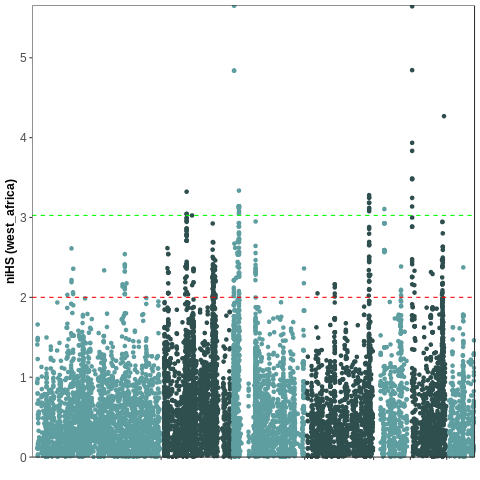

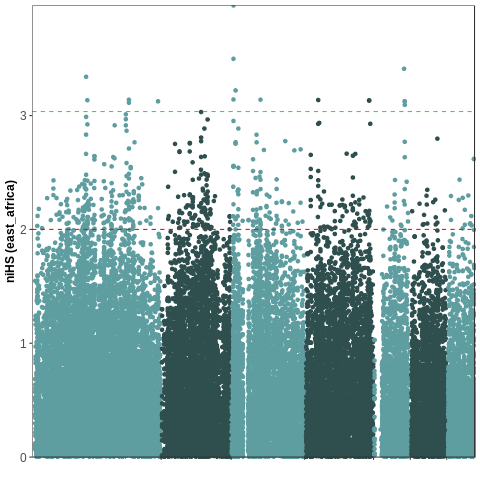

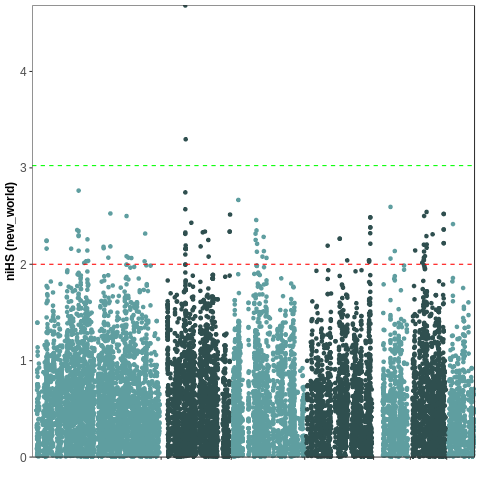

In [76]:
%%R

pops=c('west_africa', 'east_africa', 'new_world')


for (pop in pops){
    ihs_file=paste("results/ihs/", pop, "_ihs.csv", sep="")
    ihs_df<-read.csv(ihs_file, header=TRUE, sep=",")
    
    #get position for plotting
    cumul_pos<-get_cumul_pos(ihs_df$CHROM,ihs_df$POS)

    # #build dataframe
    ihs_df<-data.frame(ihs_df, cumul_pos)

    #start plotting
    p <- ggplot(ihs_df, 
                aes(x     = cumul_pos, 
                    y     = abs(IHS), 
                    color = CHROM))

    #adjust colors
    p <- p + scale_colour_manual(values = chr_colors)

    #plot data
    p <- p + geom_point(alpha = 1)

    # #add horizontal line at 99.5th Zscore and 2
    p <- p + geom_hline(yintercept = 2, 
                    linetype   = "dashed",
                    color      = "red")
#     p <- p + geom_hline(yintercept = -2, 
#                     linetype   = "dashed", 
#                     color      = "red")
    p <- p + geom_hline(yintercept = quantile(abs(ihs_df$normIHS), 0.995, na.rm=TRUE), 
                    linetype   = "dashed", 
                    color      = "green")
    #modify x and y axis
    p <- p + scale_x_continuous(name   = "", 
                                breaks = cumul_starts, 
                                expand = c(0,0))
    p <- p + scale_y_continuous(name   = paste("niHS (", pop, ")", sep=""), 
                                expand = c(0,0),
                                limits = c(0,max(abs(ihs_df$normIHS)) + 1),
                                #breaks = c(-0.2, 0, 0.2, 0.4, 0.6, 0.8)
                               )

    # #change theme
    p <- p + theme_bw()

    #change fonts on axis elements and titles
    p <- p + theme(axis.text   = element_text(size = 12),
                   axis.title  = element_text(size = 12,
                                              face = "bold"),
                   axis.text.x = element_blank())

    #removing gridlines
    p <- p + theme(panel.grid.major  = element_blank(), 
                    panel.grid.minor = element_blank())

    #set up plot title etc.
    #p <- p + ggtitle(paste("niHS (", pop, ")", sep=""))
    #p <- p + theme(plot.title = element_text(hjust = 0.5, 
    #                                         vjust = 0.5, 
    #                                         face  = 'bold', 
    #                                         size  = 18))

    #modify legend
    p <- p + theme(legend.position = "none")

    #save the figure
    #svg_img <- paste("results/ihs/", pop, "_abs_normiHS.svg", sep="")
    #png_img <- paste("results/ihs/", pop, "_abs_normiHS.png", sep="")
    #svg_img <- paste("results/ihs/", pop, "_normiHS.svg", sep="")
    #png_img <- paste("results/ihs/", pop, "_normiHS.png", sep="")
    #ggsave(png_img, plot = p, dpi = 600)
    #ggsave(svg_img, plot = p)

    #display in notebook
    print(p)
    #ihs_plots<-append(ihs_plots, p)
    #ggsave(paste("results/ihs/", pop, "_normiHS_composite.png", sep=""), plot = p, width = 10, height = 1.5, units = "in", dpi = 300)

}

## Multi-population statistics

EA v WA, EA v NW, NW v WA

### FST

In [38]:
if os.path.isdir("results/fst_per_site"):
    shutil.rmtree("results/fst_per_site")
os.mkdir("results/fst_per_site")

#create files with lists of samples per population
for sample in population_assignments:
    with open("results/fst_per_site/" + population_assignments[sample] + ".list", 'a') as list_file:
        list_file.write(sample + "\n")

In [40]:
%%bash

#east africa vs. west africa
vcftools \
    --vcf results/phasing/auto_beagle.vcf \
    --weir-fst-pop results/fst_per_site/east_africa.list \
    --weir-fst-pop results/fst_per_site/west_africa.list \
    --stdout \
    >results/fst_per_site/ea_vs_wa.fst
    
#east africa vs. new world
vcftools \
    --vcf results/phasing/auto_beagle.vcf \
    --weir-fst-pop results/fst_per_site/east_africa.list \
    --weir-fst-pop results/fst_per_site/new_world.list \
    --stdout \
    >results/fst_per_site/ea_vs_nw.fst
    
#new world vs. west africa
vcftools \
    --vcf results/phasing/auto_beagle.vcf \
    --weir-fst-pop results/fst_per_site/new_world.list \
    --weir-fst-pop results/fst_per_site/west_africa.list \
    --stdout \
    >results/fst_per_site/nw_vs_wa.fst


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf results/phasing/auto_beagle.vcf
	--weir-fst-pop results/fst_per_site/east_africa.list
	--weir-fst-pop results/fst_per_site/west_africa.list
	--keep results/fst_per_site/east_africa.list
	--keep results/fst_per_site/west_africa.list
	--stdout

Keeping individuals in 'keep' list
After filtering, kept 90 out of 155 Individuals
Outputting Weir and Cockerham Fst estimates.
Weir and Cockerham mean Fst estimate: 0.10199
Weir and Cockerham weighted Fst estimate: 0.41058
After filtering, kept 475081 out of a possible 475081 Sites
Run Time = 41.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf results/phasing/auto_beagle.vcf
	--weir-fst-pop results/fst_per_site/east_africa.list
	--weir-fst-pop results/fst_per_site/new_world.list
	--keep results/fst_per_site/east_africa.list
	--keep results/fst_per_site/new_world.list
	--stdout

Keeping individua

### DXY [TO DO]

### PBS [TO DO]

### xpehh [TO DO]

In [ ]:
if os.path.isdir("results/xpehh"):
    shutil.rmtree("results/xpehh")
os.mkdir("results/xpehh")

In [ ]:
genome_ihs=[]
genome_pos=[]
genome_chr=[]

hs={}
chrom_hs={}
chrom_pos={}

#read in vcf
phased_callset=allel.read_vcf('results/phasing/schMan_v7_exome_phased.vcf')

chrom=phased_callset['variants/CHROM']
pos=phased_callset['variants/POS']
idx=allel.ChromPosIndex(chrom, pos)

#get genotypes
phased_g=phased_callset['calldata/GT']
gt=allel.GenotypeArray(phased_g)

In [ ]:
#cycle through populations
pops = ['west_africa', 'east_africa', 'new_world']
for pop in pops:

#     #go ahead and make output file with header
#     with open("results/ihs/" + pop + "_ihs.csv", 'w') as ihs_file:
#         out="CHROM,POS,IHS,normIHS\n"
#         ihs_file.write(out)

    #get pop genotypes, allele counts, alt allele counts, and haplotypes
    pop_gt  = gt.take(sample_idx[pop], axis=1)
    pop_ac  = gt.count_alleles()
    pop_h   = pop_gt.to_haplotypes()

    #working on H stat
    hs[pop]=pop_h
    chrom_hs[pop]={}
    
    for chrom in chroms:

        #get chromosome specific data
        to_slice             = idx.locate_key(chrom)
        chr_pop_h            = pop_h[to_slice] #haplotypes
        chrom_hs[pop][chrom] = chr_pop_h
        chrom_pos[chrom]     = pos[to_slice]

Calculate xpehh from the previously stored haplotype arrays.  prints to csv file that can be imported/plotted in R

In [ ]:
#list of population comparisons for xpehh
xpehh_comparison=[["brazil",  "niger"     ],
                  ["brazil",  "senegal"  ],
                  ["brazil",  "tanzania"  ],
                  ["brazil",  "wafrica"   ],
                  ["brazil",  "africa"    ],
                  ["wafrica", "tanzania" ]]


#designate csv headerline
header = '{},{},{},{}\n'.format("CHROM", "POS", "XPEHH", "SXPEHH")
    
#make comparisons between population
for pops in xpehh_comparison:
    pop1 = pops[0]
    pop2 = pops[1]
    
    #define the outfile and print headerline
    outfile = "results/xpehh/" + pop1 + "_" + pop2 + "_xpehh.csv"
    with open(outfile, 'w') as xpehh_file:
        xpehh_file.write(header)
    
    #reset all lists
    genome_xpehh  = []
    genome_sxpehh = []
    genome_pos    = []
    genome_chr    = []
 
    #calculate xpehh(s) for each chrom.
    for chr in chroms:
    
        #xpehh
        xpehh=allel.xpehh(chrom_hs[pop1][chr], 
                          chrom_hs[pop2][chr], 
                          chrom_pos[chr], 
                          min_ehh=0.05)
        
        #standardize
        sxpehh=allel.standardize(xpehh)
        
        #add values to others per pop comparison
        genome_xpehh.extend(xpehh)
        genome_sxpehh.extend(sxpehh)
        genome_pos.extend(chrom_pos[chr])
       
        
        #print values to csv outfile
        with open(outfile, 'a') as xpehh_file:
            for i in range(len(xpehh)):
                out_line = '{},{},{},{}\n'.format(chr, 
                                                  chrom_pos[chr][i], 
                                                  xpehh[i], 
                                                  sxpehh[i])
                xpehh_file.write(out_line)

In [ ]:
%%R

#define pops in each comparison
pop1s <- c("brazil", "brazil",   "brazil",   "brazil",  "wafrica"  )
pop2s <- c("niger",  "tanzania", "wafrica",  "africa",  "tanzania" )

#iterate through the comparisons
j<-1
while (j <= length(pop1s)){

    #define pops in comparison
    pop1<-pop1s[j]
    pop2<-pop2s[j]

    #open and read xpehh infile
    xpehh_infile  <-paste("results/xpehh/", pop1, "_", pop2,"_xpehh.csv", sep="")
    xpehh<-read.csv(xpehh_infile, sep=",", header=TRUE)

    #get cumulative positions for plotting
    cumul_pos<-get_cumul_pos(xpehh$CHROM,xpehh$POS)


    #build dataframe
    xpehh<-data.frame(xpehh, cumul_pos)

    #start plotting
    p <- ggplot(xpehh, 
                aes(x     = cumul_pos, 
                    y     = SXPEHH, 
                    color = CHROM))

    #adjust colors
    p <- p + scale_colour_manual(values = chr_colors)

    #plot data
    p <- p + geom_point()

    #add horizontal line at 99.5th Zscore
    p <- p + geom_hline(yintercept = quantile(xpehh$SXPEHH, 0.995, na.rm=TRUE), 
                    linetype   = "dashed",
                    color      = "red")
    p <- p + geom_hline(yintercept = quantile(xpehh$SXPEHH, 0.005, na.rm=TRUE), 
                    linetype   = "dashed", 
                    color      = "red")

    #modify x and y axis
    p <- p + scale_x_continuous(name   = "", 
                                breaks = cumul_starts, 
                                expand = c(0,0))
    p <- p + scale_y_continuous(name   = "nxpEHH")

    # #change theme
    p <- p + theme_bw()

    #change fonts on axis elements and titles
    p <- p + theme(axis.text   = element_text(size = 12),
                   axis.title  = element_text(size = 12,
                                              face = "bold"),
                   axis.text.x = element_blank())

    #removing gridlines
    p <- p + theme(panel.grid.major  = element_blank(), 
                    panel.grid.minor = element_blank())

    #set up plot title etc.
    p <- p + ggtitle(paste("standardized xpEHH (", pop1, " v ", pop2, ")", sep=""))
    p <- p + theme(plot.title = element_text(hjust = 0.5, 
                                             vjust = 0.5, 
                                             face  = 'bold', 
                                             size  = 12))

    #modify legend
    p <- p + theme(legend.position = "none")

    #save the figure
    svg_img <- paste("results/xpehh/", pop1, "_", pop2,"_xpehh.svg", sep="")
    png_img <- paste("results/xpehh/", pop1, "_", pop2,"_xpehh.png", sep="")
    ggsave(png_img, plot = p, dpi = 600)
    ggsave(svg_img, plot = p)
    ggsave(paste("results/xpehh/", pop1, "_", pop2,"_xpehh.COMPOSITE.png", sep=""),
           plot = p, 
           dpi = 600,
           width = 10, 
           height = 1.5, 
           units = "in", 
          )
    #display in notebook
    print(p)
    #ihs_plots<-append(ihs_plots, p)
    
    j<-j+1
}

In [ ]:
%%R


# xpehh_infile  <-paste("results/xpehh/brazil_africa_xpehh.csv", sep="")
# xpehh<-read.csv(xpehh_infile, sep=",", header=TRUE)

#  xpehh<-xpehh[complete.cases(xpehh), ]

        #smooth
smoothed_med<-runmed(x = xpehh$SXPEHH, k = 201, endrule="median")

# runmed(xpehh$SXPEHH, 21)
plot(smoothed_med, pch=19, col=alpha("black", 1))
abline(h=quantile(xpehh$SXPEHH, 0.995, na.rm=TRUE), col="red")
abline(h=quantile(xpehh$SXPEHH, 0.005, na.rm=TRUE), col="red")